In [127]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import font_manager
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [49]:
# Installed roboto thin, light, and regular fonts from:
# https://fonts.google.com/specimen/Roboto
font_path = '/Users/alena.mclucas/Library/Fonts/'

system_fonts = font_manager.findSystemFonts(fontpaths=font_path, fontext='ttf')
roboto_fonts = [f for f in system_fonts if 'roboto' in f.lower()]

for roboto_font in roboto_fonts:
    font_manager.fontManager.addfont(roboto_font)

roboto_fonts

['/Users/alena.mclucas/Library/Fonts/Roboto-Regular.ttf',
 '/Users/alena.mclucas/Library/Fonts/Roboto-Thin.ttf',
 '/Users/alena.mclucas/Library/Fonts/Roboto-Light.ttf']

In [83]:
# formatting
CMAP = 'YlGn'
COLOR = 'green'

# pandas
pd.set_option('display.precision', 4)

# matplotlib, seaborn
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['axes.labelpad'] = 15
rc = {
    'font.size': 10,
    'axes.titlesize': 16,
    'axes.labelsize': 12
}
sns.set(font='Roboto')
sns.set_context('notebook', rc=rc)
sns.set_style('whitegrid', {'axes.grid' : False})
# sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

In [16]:
# credit to original source: https://github.com/allisonhorst/palmerpenguins
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We need to do basic checks before train test splitting our data. We have to check everything needed to train algorithms on it, but with caution so as not to bias our understanding by knowing too much about the data that will eventually be tested. Summary statistics should be avoided. Some important things to evaluate are:
- Are there null values? How should they be handled?
- Are there any non-numeric data types that an algorithm can't compute with?

In [17]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


I see there are a few non-null values across these fields. Let's see if they overlap on the same examples or not.

In [18]:
penguins[(penguins['bill_length_mm'].isna() | penguins['bill_depth_mm'].isna() | penguins['flipper_length_mm'].isna() | penguins['body_mass_g'].isna())]


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


If we had more than two examples to contend with, we may have considered averaging or using a more sophisticated imputation method. Because there are only two mostly null examples, let's drop them.

In [23]:
penguins = penguins[~(penguins['bill_length_mm'].isna() | penguins['bill_depth_mm'].isna() | penguins['flipper_length_mm'].isna() | penguins['body_mass_g'].isna())]


For the sake of simplicity, though this would be something to earmark and go back to later, here I choose to fill null values of sex with "Unknown."

In [33]:
penguins['sex'] = penguins['sex'].apply(lambda s: 'Unknown' if pd.isna(s) else s)

In [45]:
def train_test_by_class(df, y_col):
    # establish columns
    X_cols = list(df.columns)
    X_cols.remove(y_col)

    # create empty pandas objects to concat with
    X_train_df, X_test_df = pd.DataFrame(columns=X_cols), pd.DataFrame(columns=X_cols)
    y_train_ser, y_test_ser = pd.Series(name=y_col), pd.Series(name=y_col)

    # randomly assigns by class
    for this_class in df[y_col].unique():
        this_class_df = df[df[y_col] == this_class]
        X_tr, X_te, y_tr, y_te = train_test_split(this_class_df[X_cols], this_class_df[y_col],
                                                  test_size=0.3, random_state=42)
        X_train_df = pd.concat([X_train_df, X_tr], ignore_index=True)
        X_test_df = pd.concat([X_test_df, X_te], ignore_index=True)
        y_train_ser = pd.concat([y_train_ser, y_tr], ignore_index=True)
        y_test_ser = pd.concat([y_test_ser, y_te], ignore_index=True)
    
    return X_train_df, X_test_df, y_train_ser, y_test_ser

X_train, X_test, y_train, y_test = train_test_by_class(penguins, 'species')

Now, we can begin feature engineering.

---

We are taught that every model has a set of assumptions that the underlying data must be adhering to. In practice, many rarely take the time to confirm if this is true. Each model has it's own assumptions, and so feature engineering will largely be on a case-by-case basis. To illustrate, we will focus on a very common one: the normality assumption.

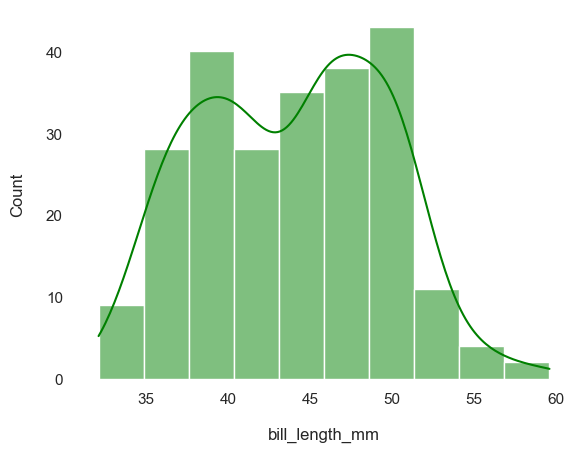

In [77]:
sns.histplot(data=X_train, x='bill_length_mm', kde=True, color='green')
sns.despine(top=True, right=True, left=True, bottom=True)

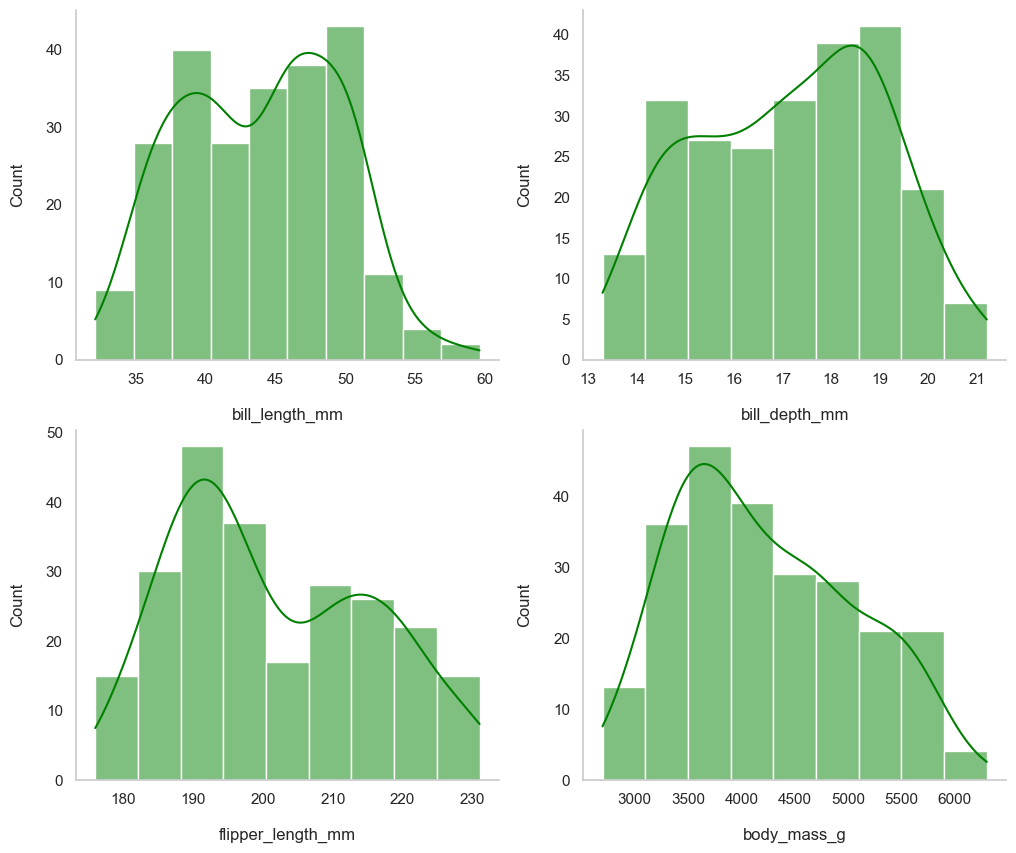

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.histplot(data=X_train, x='bill_length_mm', kde=True, color=COLOR, ax=ax[0, 0])
sns.histplot(data=X_train, x='bill_depth_mm', kde=True, color=COLOR, ax=ax[0, 1])
sns.histplot(data=X_train, x='flipper_length_mm', kde=True, color=COLOR, ax=ax[1, 0])
sns.histplot(data=X_train, x='body_mass_g', kde=True, color=COLOR, ax=ax[1, 1])
sns.despine(top=True, right=True)

Another common issue is that many algorithms require scaling. This is because, if certain variables are many orders of magnitude higher, they will be accounted for more heavily by an objective function attempting to converge. It's considered best practice to have features centered at 0 with variances in the same order.

In practice, most datasets do not match this criteria. We already know intuitively that three of these variables are in millimeters while one is in grams. To verify ours will benefit from scaling, we can look at means, standard deviations, and quartiles for our data. They can be in table form or with visualizations like boxplots.

In [103]:
X_train.describe().round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,238.00,238.00,238.00,238.00
mean,43.93,17.16,201.45,4227.42
std,5.66,1.92,14.11,824.21
min,32.10,13.30,176.00,2700.00
25%,39.20,15.60,190.00,3550.00
50%,45.10,17.25,198.00,4075.00
75%,48.58,18.68,213.00,4800.00
max,59.60,21.20,231.00,6300.00


<Axes: >

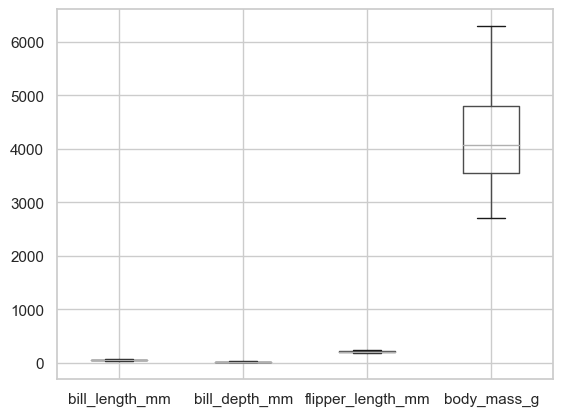

In [104]:
X_train.boxplot()

Here we see predictable results. The variable in grams has a mean of 4,227, while the average of the variables in millimeters range from 17 to 201. Even amongst the variables in millimeters, the variances are several magnitudes aparts. This data will perform best with scaling.

You may know that standardization is one of the most common scaling approaches. Why is that?

In standardization:

$z=\frac{x-\mu}{\sigma}$

subtracting the mean centers the data around 0, and then dividing the result by the standard deviation scales the variance to 1.

A common mistake is to fit and transform on data that appears in both the train and test set. These results will be misleading because, in the future, you can't train your scaler on the data you have yet to predict for. This is a form of data leakage. Always train any scalers on only your training set.

In [118]:
quant_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
standard_scaler = StandardScaler()
X_train_standard = pd.DataFrame(standard_scaler.fit_transform(X_train[quant_cols]), columns=quant_cols)
X_train_standard.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-1.0334,-0.3450,-0.2447,-0.4893
1,-0.4311,0.5921,-0.4577,0.0883
2,-0.5374,-0.1888,-0.7418,-0.6413
3,-0.7677,1.8416,-0.7418,-0.3981
4,-1.4939,-0.5011,-0.4577,-1.0668


Now, let's take a look at their distributions again.

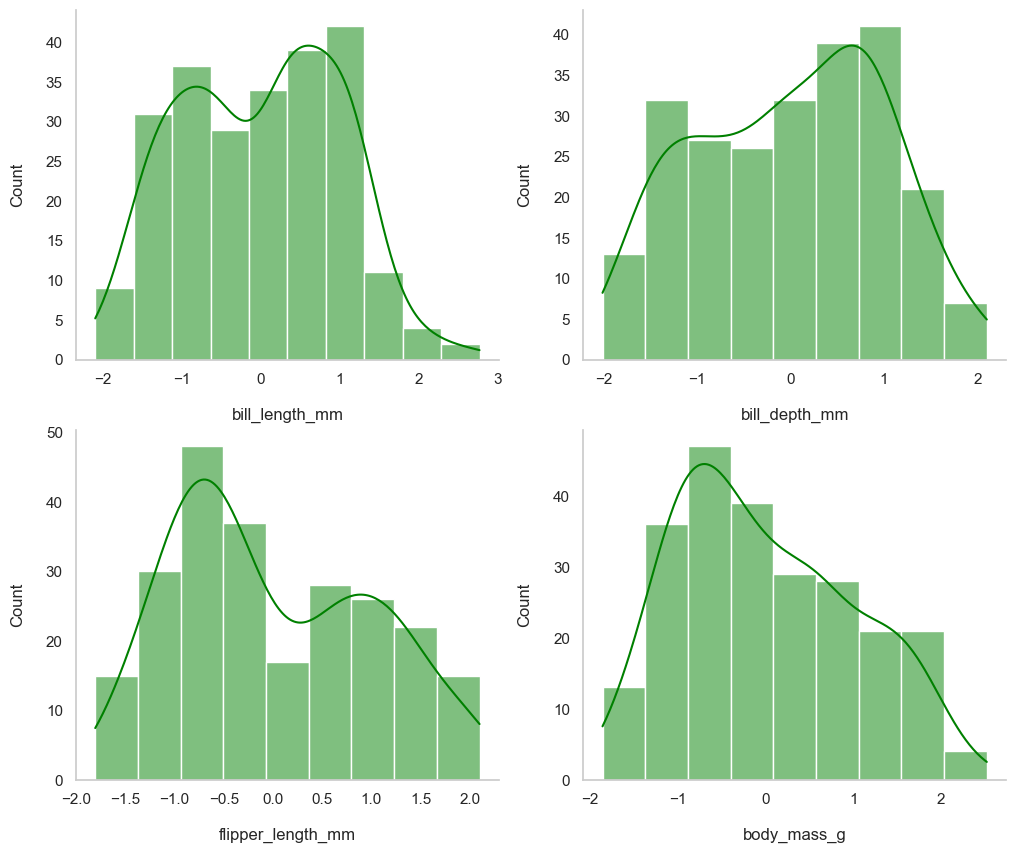

In [119]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.histplot(data=X_train_standard, x='bill_length_mm', kde=True, color=COLOR, ax=ax[0, 0])
sns.histplot(data=X_train_standard, x='bill_depth_mm', kde=True, color=COLOR, ax=ax[0, 1])
sns.histplot(data=X_train_standard, x='flipper_length_mm', kde=True, color=COLOR, ax=ax[1, 0])
sns.histplot(data=X_train_standard, x='body_mass_g', kde=True, color=COLOR, ax=ax[1, 1])
sns.despine(top=True, right=True)

In [120]:
X_train_standard.describe().round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,238.00,238.00,238.00,238.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.10,-2.01,-1.81,-1.86
25%,-0.84,-0.81,-0.81,-0.82
50%,0.21,0.05,-0.24,-0.19
75%,0.82,0.79,0.82,0.70
max,2.77,2.10,2.10,2.52


The scaling has worked, but in this case the distributions don't appear to be more normal.

All of these variables are skewed?, so let's look at a log transformation:

In [124]:
power_scaler = PowerTransformer(method='box-cox').  # vs default 'yeo-johnson'
X_train_power = pd.DataFrame(power_scaler.fit_transform(X_train[quant_cols]), columns=quant_cols)
X_train_power.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-1.0341,-0.3605,-0.1412,-0.4041
1,-0.4138,0.5826,-0.3756,0.2048
2,-0.5221,-0.2053,-0.7072,-0.5797
3,-0.7584,1.8831,-0.7072,-0.3021
4,-1.5203,-0.5148,-0.3756,-1.1124


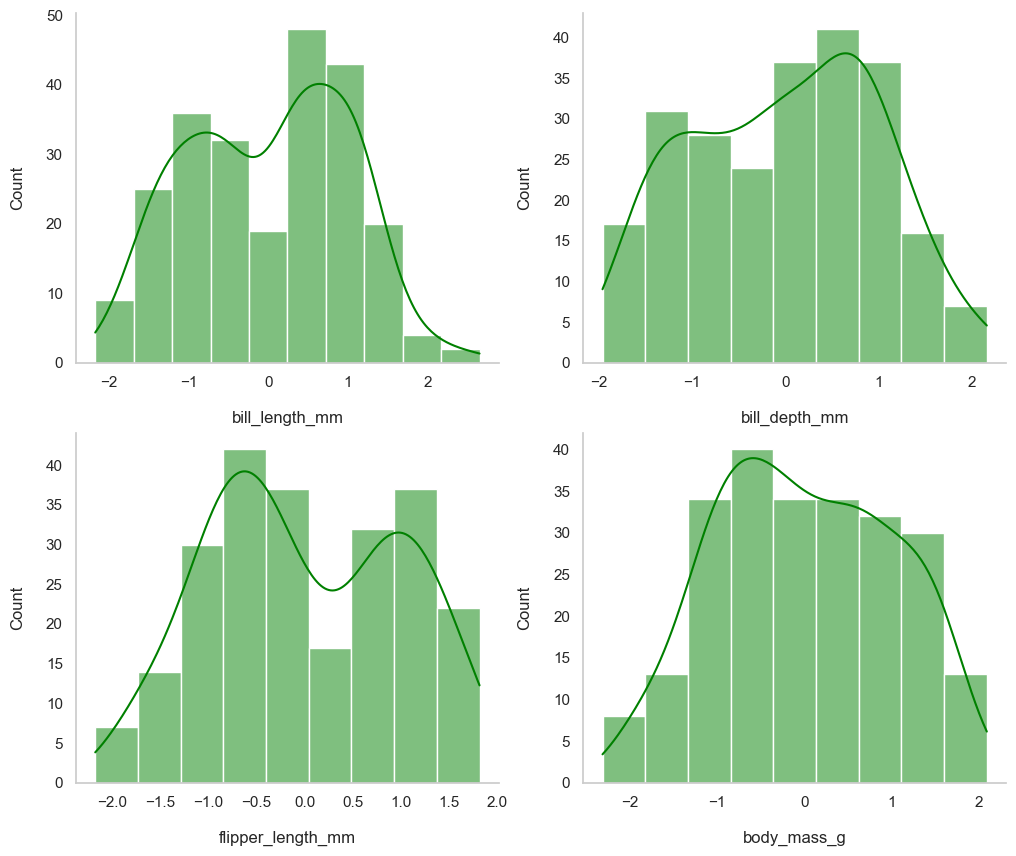

In [125]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.histplot(data=X_train_power, x='bill_length_mm', kde=True, color=COLOR, ax=ax[0, 0])
sns.histplot(data=X_train_power, x='bill_depth_mm', kde=True, color=COLOR, ax=ax[0, 1])
sns.histplot(data=X_train_power, x='flipper_length_mm', kde=True, color=COLOR, ax=ax[1, 0])
sns.histplot(data=X_train_power, x='body_mass_g', kde=True, color=COLOR, ax=ax[1, 1])
sns.despine(top=True, right=True)

Some improvement!

In [136]:
sns.histplot(data=pd.DataFrame(np.abs(X_train['bill_length_mm'] - X_train['bill_length_mm'].mean())), x='bill_length_mm', kde=True, color=COLOR, ax=ax[0, 0])


<Axes: xlabel='bill_length_mm', ylabel='Count'>

In [132]:
np.abs(X_train['bill_length_mm'] - X_train['bill_length_mm'].mean())

0      5.834
1      2.434
2      3.034
3      4.334
4      8.434
       ...  
233    2.234
234    1.866
235    1.566
236    4.566
237    3.266
Name: bill_length_mm, Length: 238, dtype: float64

In [144]:
def absolute_diff_from_avg(ser):
    return np.abs(ser - ser.mean())

X_train_abs_diff = X_train.copy(deep=True)
for col_name in quant_cols:
    X_train_abs_diff[col_name] = absolute_diff_from_avg(X_train_abs_diff[col_name])

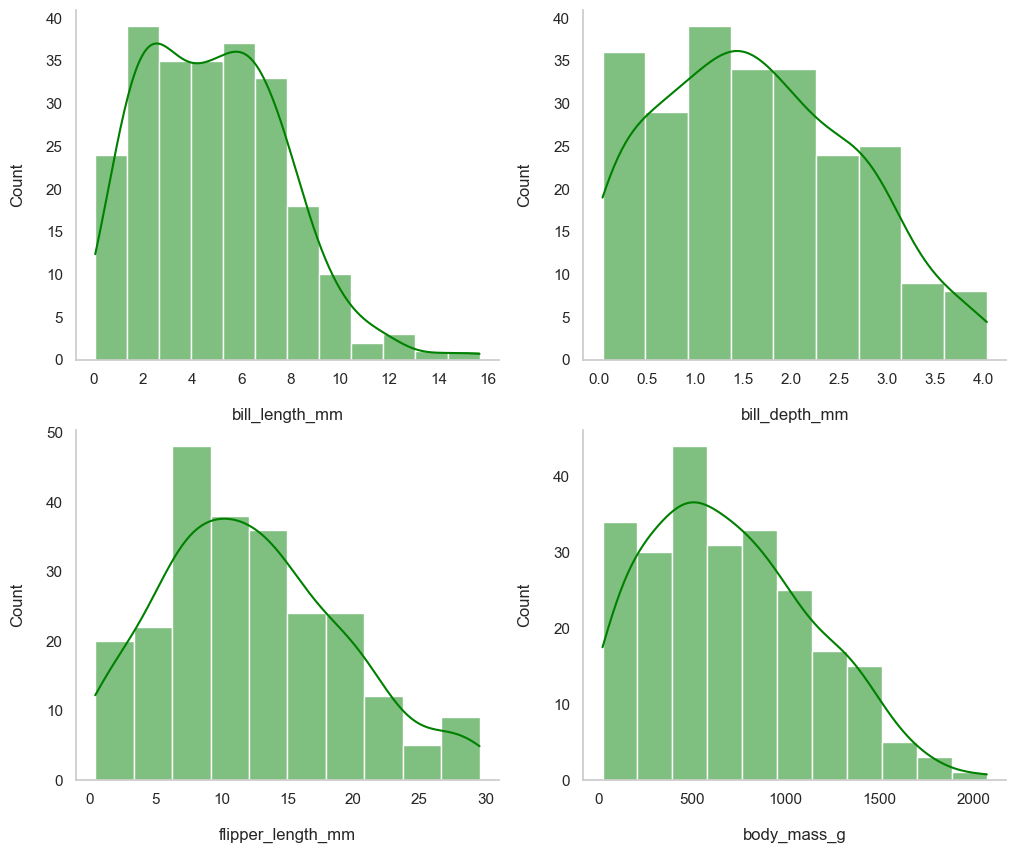

In [145]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.histplot(data=X_train_abs_diff, x='bill_length_mm', kde=True, color=COLOR, ax=ax[0, 0])
sns.histplot(data=X_train_abs_diff, x='bill_depth_mm', kde=True, color=COLOR, ax=ax[0, 1])
sns.histplot(data=X_train_abs_diff, x='flipper_length_mm', kde=True, color=COLOR, ax=ax[1, 0])
sns.histplot(data=X_train_abs_diff, x='body_mass_g', kde=True, color=COLOR, ax=ax[1, 1])
sns.despine(top=True, right=True)

In [217]:
import math
from tabulate import tabulate
from pingouin import qqplot
from scipy.stats import kstest, shapiro, anderson

In [210]:
kstest(X_train['bill_length_mm'], 'norm', alternative='less')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=32.1, statistic_sign=-1)

In [194]:
shapiro(X_train['bill_length_mm'])

ShapiroResult(statistic=0.9738687872886658, pvalue=0.00022337307746056467)

╭───────────┬─────────────────────┬────────────────┬────────────────────╮
│           │   kolmogrov-smirnov │   shapiro-wilk │   anderson-darling │
├───────────┼─────────────────────┼────────────────┼────────────────────┤
│ statistic │              1.0000 │         0.9739 │             2.2620 │
│ p-value   │              0.0000 │         0.0002 │             0.0000 │
╰───────────┴─────────────────────┴────────────────┴────────────────────╯


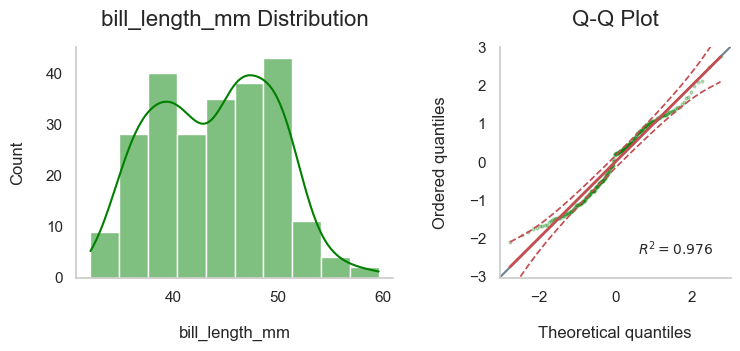

In [228]:
def normality_check(df, col_name):
    # p-value is not natively supported by scipy, though it does supply us with
    # significance levels and critical values so hypothesis testing is still doable
    # for ease of comparison, I calculate the p-value using an adjusted
    # anderson-darling statistic as described here:
    # https://www.spcforexcel.com/knowledge/basic-statistics/anderson-darling-test-for-normality#p_value
    def aad(ad, n):
        return ad * (1 + (0.75 / n) + (2.25 / (n ** 2)))

    def aad_pvalue(aad):
        if aad >= 0.6:
            return math.exp(1.2937 - (5.709 * aad) + (0.0186 * aad ** 2))
        elif aad >= 0.34:
            return math.exp(0.9177 - (4.279 * aad) - (1.38 * aad ** 2))
        elif aad >= 0.2:
            return 1 - math.exp(-8.318 + (42.796 * aad) - (59.938 * aad ** 2))
        else:
            return 1 - math.exp(-13.436 + (101.14 * aad) - (223.73 * aad ** 2))
    
    # plots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
    ax[0].set_title(f"{col_name} Distribution")
    sns.histplot(data=df, x=col_name, kde=True, color=COLOR, ax=ax[0])
    ax[1].set_title('Q-Q Plot')
    qqplot(df[col_name], dist='norm', confidence=0.95, color=COLOR, s=4, alpha=0.25, ax=ax[1])
    sns.despine(top=True, right=True)

    # hypothesis tests
    # kolmogrov-smirnov test
    kstest_results = kstest(df[col_name], 'norm', alternative='less')

    # shapiro-wilk test
    swtest_results = shapiro(df[col_name])

    # anderson-darling test
    adtest_results = anderson(df[col_name])
    aad_stat = aad(adtest_results.statistic, len(df[col_name]))   # adjusted ad stat
    

    test_names = ['kolmogrov-smirnov', 'shapiro-wilk', 'anderson-darling']
    test_index = ['statistic', 'p-value']
    test_results = np.array([
        [kstest_results.statistic, swtest_results.statistic, aad_stat],
        [kstest_results.pvalue, swtest_results.pvalue, aad_pvalue(aad_stat)]
    ])
    
    print(tabulate(pd.DataFrame(data=test_results, columns=test_names, index=test_index),
                   headers='keys', floatfmt='.4f', tablefmt='rounded_outline')) 


normality_check(X_train, 'bill_length_mm')

In [214]:
anderson(X_train['bill_length_mm']).statistic

2.2548166108412033

In [201]:


aad_stat = aad(ad_stat, len(X_train['bill_length_mm']))

In [106]:
# # we'll see
# g = sns.PairGrid(X_train)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)

Imbalanced multi-class

In [107]:
# penguins['island'].value_counts()

- In the case of classification, is the outcome variable balanced or imbalanced? This ma